# Random Forest Fake News Classifier

Este notebook implementa um classificador Random Forest para detectar notícias falsas usando o dataset FakeBr News.

## Objetivo
Criar um modelo Random Forest que classifique notícias como verdadeiras ou falsas baseado no texto pré-processado (`preprocessed_text`).

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Configuração de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Carregamento dos Dados

In [4]:
# Carregar dados do parquet
df = pd.read_parquet('../data/processed/fakebr_news.parquet')

print(f"Dataset shape: {df.shape}")
print(f"\nColunas disponíveis: {df.columns.tolist()}")
print(f"\nDistribuição de classes:")
print(df['is_fake'].value_counts())
print(f"\nPorcentagem:")
print(df['is_fake'].value_counts(normalize=True) * 100)

Dataset shape: (7200, 31)

Colunas disponíveis: ['id', 'full_text', 'preprocessed_text', 'size_normalized_text', 'author', 'link', 'category', 'publication_date', 'is_fake', 'text_hash', 'created_at', 'updated_at', 'num_tokens', 'num_palavras_sem_pontuacao', 'num_tipos', 'num_links_internos', 'num_palavras_maiuscula', 'num_verbos', 'num_nomes', 'num_adjetivos', 'num_adverbios', 'num_pronomes', 'num_caracteres', 'avg_sent_length', 'avg_word_length', 'pausality', 'emotiveness', 'diversity', 'percentage_spelling_errors', 'publication_date_as_date', 'sequence']

Distribuição de classes:
is_fake
True     3600
False    3600
Name: count, dtype: int64

Porcentagem:
is_fake
True     50.0
False    50.0
Name: proportion, dtype: float64


In [5]:
# Verificar dados faltantes no preprocessed_text
print(f"Valores nulos em preprocessed_text: {df['preprocessed_text'].isnull().sum()}")
print(f"Valores vazios em preprocessed_text: {(df['preprocessed_text'] == '').sum()}")

# Remover linhas com texto vazio ou nulo
df_clean = df[df['preprocessed_text'].notna() & (df['preprocessed_text'] != '')].copy()
print(f"\nDataset após limpeza: {df_clean.shape}")

Valores nulos em preprocessed_text: 0
Valores vazios em preprocessed_text: 0

Dataset após limpeza: (7200, 31)


## 2. Preparação dos Dados

In [6]:
# Separar features (X) e target (y)
X = df_clean['preprocessed_text'].values
y = df_clean['is_fake'].values.astype(int)

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nDistribuição de y:")
print(f"Fake (1): {y.sum()} ({y.sum()/len(y)*100:.2f}%)")
print(f"True (0): {len(y) - y.sum()} ({(len(y) - y.sum())/len(y)*100:.2f}%)")

Shape de X: (7200,)
Shape de y: (7200,)

Distribuição de y:
Fake (1): 3600 (50.00%)
True (0): 3600 (50.00%)


In [7]:
# Split estratificado mantendo os pares juntos
unique_sequences = df_clean['sequence'].unique()
train_sequences, test_sequences = train_test_split(
    unique_sequences, 
    test_size=0.2, 
    random_state=42
)

# Criar máscaras para train e test
train_mask = df_clean['sequence'].isin(train_sequences)
test_mask = df_clean['sequence'].isin(test_sequences)

X_train = df_clean[train_mask]['preprocessed_text'].values
X_test = df_clean[test_mask]['preprocessed_text'].values
y_train = df_clean[train_mask]['is_fake'].values.astype(int)
y_test = df_clean[test_mask]['is_fake'].values.astype(int)

print(f"Tamanho do conjunto de treino: {len(X_train)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")
print(f"\nDistribuição no treino - Fake: {y_train.sum()}, True: {len(y_train) - y_train.sum()}")
print(f"Distribuição no teste - Fake: {y_test.sum()}, True: {len(y_test) - y_test.sum()}")

Tamanho do conjunto de treino: 5760
Tamanho do conjunto de teste: 1440

Distribuição no treino - Fake: 2880, True: 2880
Distribuição no teste - Fake: 720, True: 720


## 3. Vetorização do Texto (TF-IDF)

In [8]:
# Criar vetorizador TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

# Fit e transform no conjunto de treino
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Shape de X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape de X_test_tfidf: {X_test_tfidf.shape}")
print(f"\nNúmero de features: {len(tfidf.get_feature_names_out())}")

Shape de X_train_tfidf: (5760, 5000)
Shape de X_test_tfidf: (1440, 5000)

Número de features: 5000


## 4. Treinamento do Random Forest

### 4.1 Modelo Baseline

In [ ]:
# Treinar Random Forest baseline
print("Treinando Random Forest baseline...")
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,  # Limitar profundidade
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
rf_baseline.fit(X_train_tfidf, y_train)

# Predições
y_pred_train = rf_baseline.predict(X_train_tfidf)
y_pred_test = rf_baseline.predict(X_test_tfidf)

# Avaliação
print("\n=== Resultados Random Forest Baseline ===")
print(f"Acurácia no treino: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Acurácia no teste: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"F1-Score no teste: {f1_score(y_test, y_pred_test):.4f}")

print("\nClassification Report (Teste):")
print(classification_report(y_test, y_pred_test, target_names=['True News', 'Fake News']))

Treinando Random Forest baseline...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.



=== Resultados Random Forest Baseline ===
Acurácia no treino: 1.0000
Acurácia no teste: 0.9597
F1-Score no teste: 0.9598

Classification Report (Teste):
              precision    recall  f1-score   support

   True News       0.96      0.96      0.96       720
   Fake News       0.96      0.96      0.96       720

    accuracy                           0.96      1440
   macro avg       0.96      0.96      0.96      1440
weighted avg       0.96      0.96      0.96      1440



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


### 4.2 Otimização de Hiperparâmetros

In [10]:
# Grid Search para Random Forest
print("Executando Grid Search para Random Forest...")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=1,
    verbose=2
)

grid_search.fit(X_train_tfidf, y_train)

print(f"\nMelhores parâmetros: {grid_search.best_params_}")
print(f"Melhor F1-Score (CV): {grid_search.best_score_:.4f}")

# Usar o melhor modelo
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_tfidf)

print("\n=== Resultados do Melhor Modelo ===")
print(f"Acurácia no teste: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"F1-Score no teste: {f1_score(y_test, y_pred_best):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['True News', 'Fake News']))

Executando Grid Search para Random Forest...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   2.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_

## 5. Visualização dos Resultados

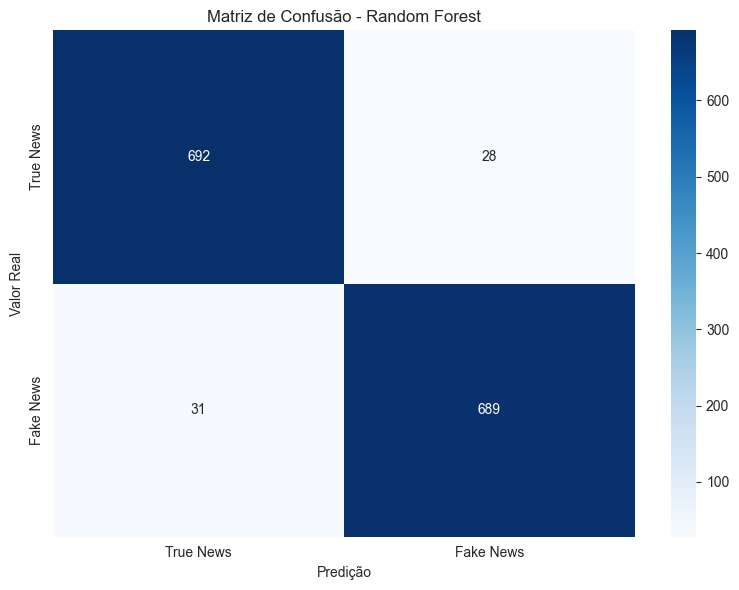


Métricas da Matriz de Confusão:
True Negatives (TN): 692
False Positives (FP): 28
False Negatives (FN): 31
True Positives (TP): 689

Precisão: 0.9609
Recall: 0.9569


In [11]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['True News', 'Fake News'],
            yticklabels=['True News', 'Fake News'])
plt.title('Matriz de Confusão - Random Forest')
plt.ylabel('Valor Real')
plt.xlabel('Predição')
plt.tight_layout()
plt.show()

# Calcular métricas da matriz de confusão
tn, fp, fn, tp = cm.ravel()
print(f"\nMétricas da Matriz de Confusão:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"\nPrecisão: {tp/(tp+fp):.4f}")
print(f"Recall: {tp/(tp+fn):.4f}")

## 6. Feature Importance

Top 20 Features Mais Importantes:
feira                         : 0.026646
segundo                       : 0.026304
nesta                         : 0.023352
ainda                         : 0.015709
ter                           : 0.015701
sobre                         : 0.014375
sao                           : 0.014174
ano                           : 0.011090
segunda                       : 0.010932
dois                          : 0.010762
ha                            : 0.010172
anos                          : 0.010027
diz                           : 0.009951
afirmou                       : 0.009847
primeira                      : 0.009765
tres                          : 0.009210
tambem                        : 0.009071
ja                            : 0.008840
ate                           : 0.008655
dia                           : 0.008386


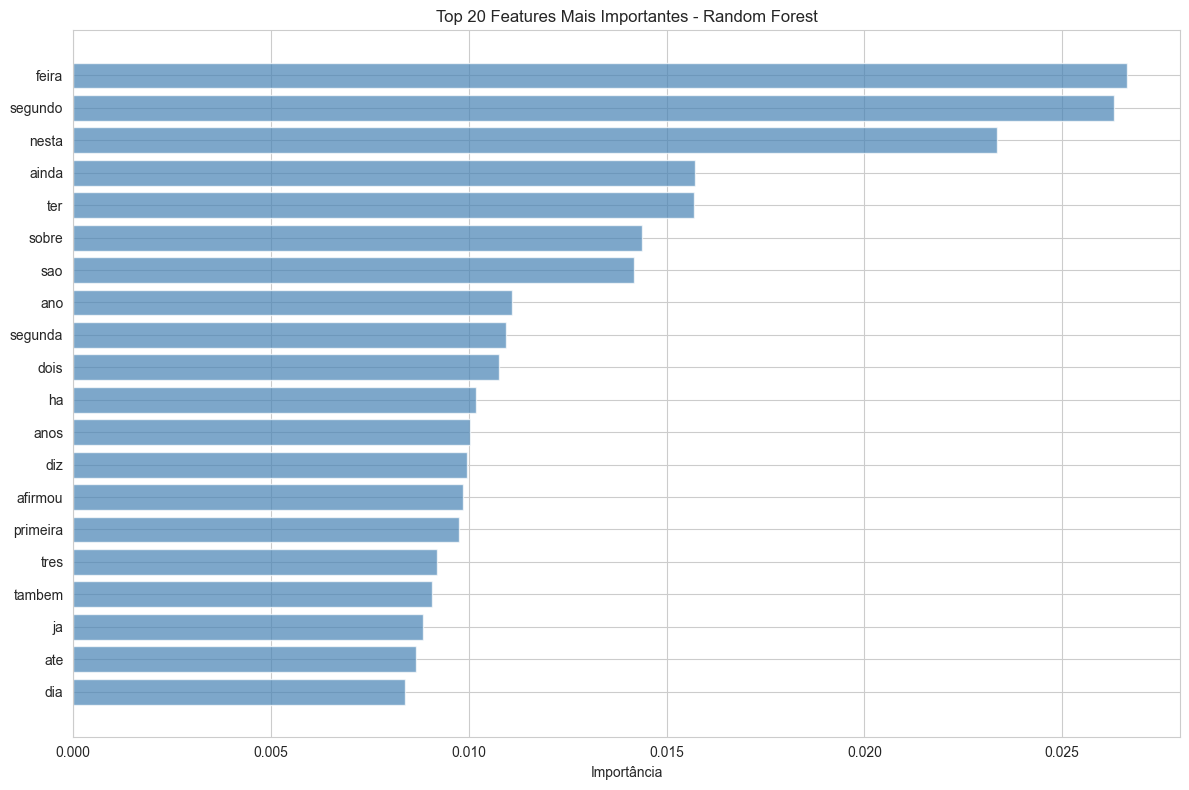

In [12]:
# Obter importância das features
feature_names = tfidf.get_feature_names_out()
importances = best_rf.feature_importances_

# Top 20 features mais importantes
top_indices = np.argsort(importances)[-20:]
top_features = [(feature_names[i], importances[i]) for i in top_indices]

print("Top 20 Features Mais Importantes:")
for feature, importance in reversed(top_features):
    print(f"{feature:30s}: {importance:.6f}")

# Visualizar
plt.figure(figsize=(12, 8))
features_df = pd.DataFrame(top_features, columns=['Feature', 'Importance'])
plt.barh(features_df['Feature'], features_df['Importance'], color='steelblue', alpha=0.7)
plt.title('Top 20 Features Mais Importantes - Random Forest')
plt.xlabel('Importância')
plt.tight_layout()
plt.show()

## 7. Curva ROC

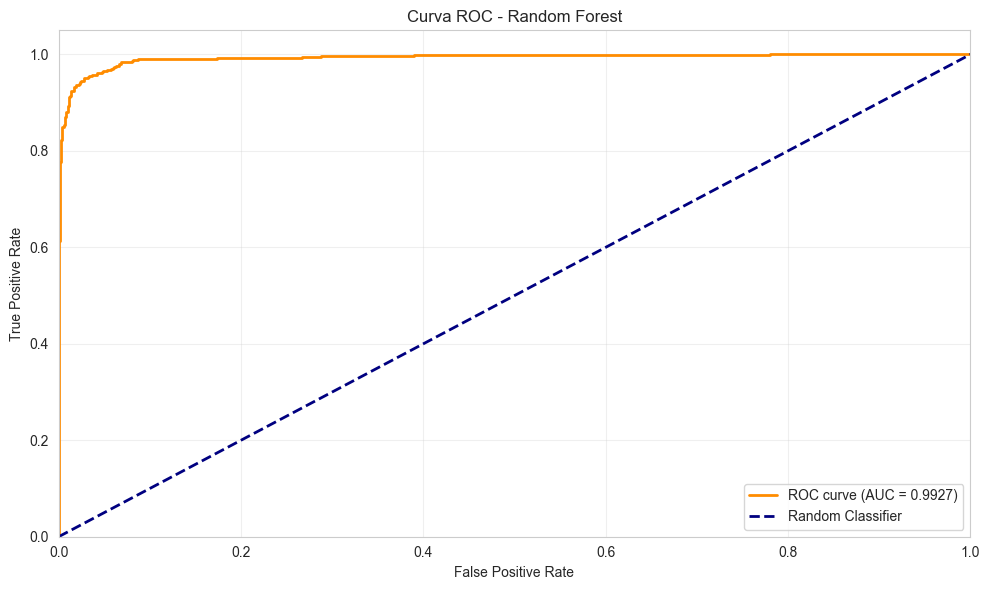

ROC AUC Score: 0.9927


In [13]:
# Calcular probabilidades
y_pred_proba = best_rf.predict_proba(X_test_tfidf)[:, 1]

# Calcular ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plotar curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Random Forest')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

## 8. Validação Cruzada

Executando validação cruzada (5-fold)...

F1-Scores por fold: [0.92040256 0.98083624 0.95598592 0.99049265 0.94243421]
Média: 0.9580
Desvio padrão: 0.0254


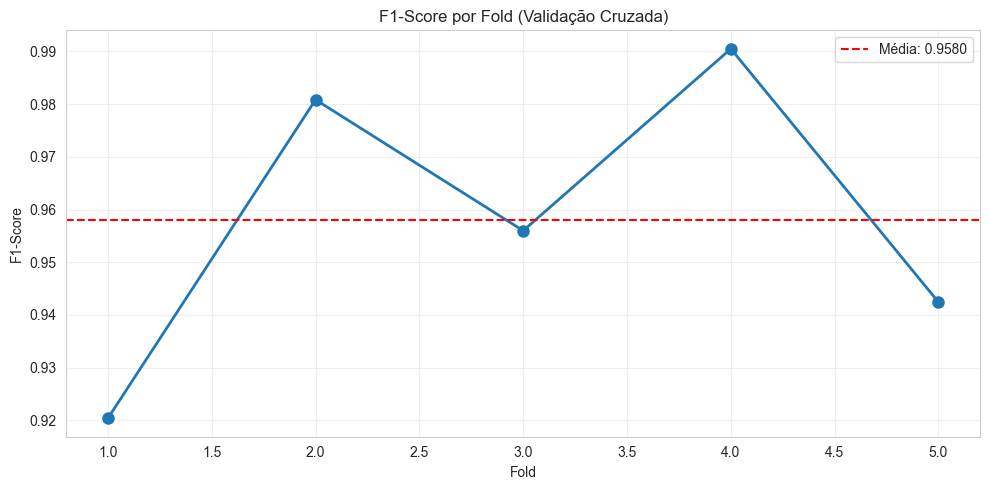

In [14]:
# Realizar validação cruzada com 5 folds
print("Executando validação cruzada (5-fold)...")
cv_scores = cross_val_score(best_rf, X_train_tfidf, y_train, cv=5, scoring='f1')

print(f"\nF1-Scores por fold: {cv_scores}")
print(f"Média: {cv_scores.mean():.4f}")
print(f"Desvio padrão: {cv_scores.std():.4f}")

# Visualizar scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Média: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('F1-Score')
plt.title('F1-Score por Fold (Validação Cruzada)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Salvar o Modelo

In [ ]:
import pickle
import os

# Criar diretório de modelos se não existir
os.makedirs('../models', exist_ok=True)

# Salvar modelo e vetorizador
with open('../models/random_forest_classifier.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

with open('../models/tfidf_vectorizer_rf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print("Modelo e vetorizador salvos com sucesso!")
print("- ../models/random_forest_classifier.pkl")
print("- ../models/tfidf_vectorizer_rf.pkl")

## 10. Teste com Exemplos

In [15]:
# Função para predizer novos textos
def predict_news(text, model, vectorizer):
    text_tfidf = vectorizer.transform([text])
    prediction = model.predict(text_tfidf)[0]
    probability = model.predict_proba(text_tfidf)[0]
    return "FAKE" if prediction == 1 else "TRUE", probability

# Testar com alguns exemplos do conjunto de teste
print("Exemplos de Predições:\n")
for i in range(5):
    idx = np.random.randint(0, len(X_test))
    text = X_test[idx]
    real_label = "FAKE" if y_test[idx] == 1 else "TRUE"
    predicted_label, proba = predict_news(text, best_rf, tfidf)
    
    print(f"Texto: {text[:100]}...")
    print(f"Real: {real_label} | Predição: {predicted_label}")
    print(f"Probabilidades - True: {proba[0]:.4f}, Fake: {proba[1]:.4f}")
    print(f"Correto: {'✓' if real_label == predicted_label else '✗'}")
    print("-" * 80)
    print()

Exemplos de Predições:

Texto: cop 23 termina participacao eua pedido ambicao metas. quase 200 paises reuniram alemanha debater est...
Real: TRUE | Predição: TRUE
Probabilidades - True: 0.7292, Fake: 0.2708
Correto: ✓
--------------------------------------------------------------------------------

Texto: lacrou! medica mg manda reposta plantonista debochou paciente semi-analfabeto. medico cidade turisti...
Real: FAKE | Predição: FAKE
Probabilidades - True: 0.0631, Fake: 0.9369
Correto: ✓
--------------------------------------------------------------------------------

Texto: tentador acreditar previsto previsivel malogro reforma previdencia atuais circunstancias decorre imp...
Real: TRUE | Predição: TRUE
Probabilidades - True: 0.8655, Fake: 0.1345
Correto: ✓
--------------------------------------------------------------------------------

Texto: sede jornal "o estado s. paulo" recebe ameaca bomba policia esvazia predio. . sede jornal estado s. ...
Real: FAKE | Predição: FAKE
Probabili

## 11. Conclusões

Este notebook implementou um classificador Random Forest para detectar notícias falsas.

### Principais Resultados:
- Modelo treinado com texto pré-processado
- Vetorização TF-IDF com unigramas e bigramas
- Otimização de hiperparâmetros via Grid Search
- Análise de importância das features
- Validação cruzada para avaliar robustez

### Vantagens do Random Forest:
- Menos propenso a overfitting que árvores individuais
- Fornece importância das features
- Robusto a outliers
- Bom desempenho sem muita otimização